In [1]:
import seapy
import Obs_workspace as ow
import numpy as np
import matplotlib.pyplot as plt

NumExpr defaulting to 8 threads.


In [2]:
grdfile = '/Volumes/TO_1/outputs_SCORRECTION/ocean_ecs_fwd_15461_outer1.nc'
dt = 1/24/60
grid = seapy.model.asgrid(grdfile)

In [3]:
# add kodc obs
import datetime
ctd_file = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/KODC_YS.txt'
ctd_id = open(ctd_file)

ctd_id.readline()

line= ctd_id.readlines()

line = [iline.split('\t') for iline in line]

iline = 0
irecord = 1
for crt_line in line:
    if iline == 0:
        kodc_record = [irecord,]
        kodc_line = [float(crt_line[1]),]
        kodc_station = [float(crt_line[2]),]
        kodc_time = (datetime.datetime.strptime(crt_line[3],'%Y-%m-%d %H:%M')-
                     datetime.timedelta(hours=9) - 
                    datetime.datetime(1970,1,1)).total_seconds()/3600/24
        # print('KST:',crt_line[3])
        # print('UTC:',(datetime.timedelta(days=kodc_time)+datetime.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M',))
        kodc_lat = float(crt_line[4])
        kodc_lon = float(crt_line[5])
        kodc_depth = float(crt_line[7])
        kodc_temp = float(crt_line[8])
        kodc_tqc = float(crt_line[9])
        kodc_salt = float(crt_line[10])
        kodc_sqc = float(crt_line[11])
        
    else:
        if kodc_line[-1] != float(crt_line[1]): irecord+=1
        kodc_record = np.r_[kodc_record,irecord]
        kodc_line = np.r_[kodc_line,float(crt_line[1])]
        kodc_station = np.r_[kodc_station,float(crt_line[2])]
        kodc_time = np.r_[kodc_time, (datetime.datetime.strptime(crt_line[3],'%Y-%m-%d %H:%M')-
                                      datetime.timedelta(hours=9) - 
                                      datetime.datetime(1970,1,1)).total_seconds()/3600/24]
        # print('KST:',crt_line[3])
        # print('UTC:',(datetime.timedelta(days=kodc_time[-1])+datetime.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M',))
        kodc_lat = np.r_[kodc_lat,float(crt_line[4])]
        kodc_lon = np.r_[kodc_lon,float(crt_line[5])]
        kodc_depth = np.r_[kodc_depth, float(crt_line[7])]
        kodc_temp = np.r_[kodc_temp, float(crt_line[8])]
        kodc_tqc = np.r_[kodc_tqc,float(crt_line[9])]
        kodc_salt = np.r_[kodc_salt, float(crt_line[10])]
        kodc_sqc = np.r_[kodc_sqc,float(crt_line[11])]
        
        
    iline+=1
ctd_id.close()
for iline in [107.,106.,105.,104.,103.,102.,209.,208.,207.]:
    exclude_pos = np.where(kodc_line != iline)
    kodc_record = kodc_record[exclude_pos]
    kodc_station = kodc_station[exclude_pos]
    kodc_time = kodc_time[exclude_pos]
    kodc_lat = kodc_lat[exclude_pos]
    kodc_lon = kodc_lon[exclude_pos]
    kodc_depth = kodc_depth[exclude_pos]
    kodc_temp = kodc_temp[exclude_pos]
    kodc_tqc = kodc_tqc[exclude_pos]
    kodc_salt = kodc_salt[exclude_pos]
    kodc_sqc = kodc_sqc[exclude_pos]
    kodc_line =kodc_line[exclude_pos]

In [4]:
data = [seapy.roms.obs.raw_data("TEMP", "CTD", kodc_temp,None,0.1),
                seapy.roms.obs.raw_data("SALT", "CTD", kodc_salt,None,0.01),]
kodc_obs = seapy.roms.obs.gridder_ctd(grid,kodc_time,
                                                kodc_lon,kodc_lat,-kodc_depth, 
                                                data,dt,title="CTD observation KODC")

Output()

In [5]:
#load sst_with cruise
withcruise_obs = seapy.roms.obs.obs(filename='/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/sst_withcruise_2012.nc')
withcruise_obs_org = withcruise_obs.copy()


In [6]:
# merge with sst_with cruise
withcruise_obs.add(kodc_obs)
# super observation
merge_obs = seapy.roms.obs.gridder_s(grid,withcruise_obs,dt)

Output()

In [7]:
merge_obs.to_netcdf('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/sst_withcruisepkodc_2012.nc')

In [9]:
final_obs = seapy.roms.obs.obs(filename='/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/sst_withcruisepkodc_2012.nc')

In [12]:
thisyppe = np.where(final_obs.type==6)

In [18]:
thisdepth = np.where(final_obs.depth[thisyppe ]==0)

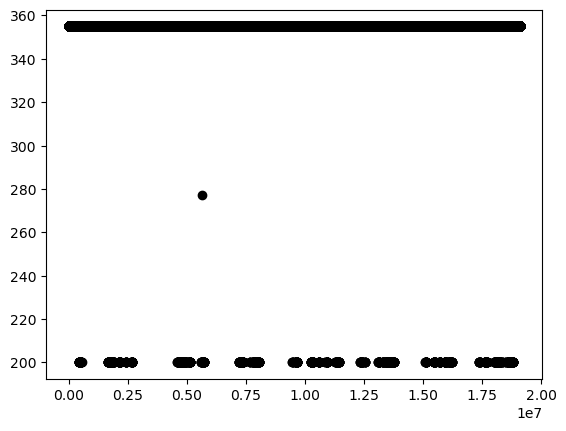

In [19]:
plt.plot(final_obs.provenance[thisyppe][thisdepth],'ko')

In [8]:
for itime in kodc_obs.time:
    if itime in withcruise_obs_org.time:
        print(itime)

15584.5
15584.5
15584.5
15584.5
15584.5
15584.5
15584.5
15584.5
15584.5
15584.5
15584.5
15584.5
15812.5
15812.5
15812.5
15812.5
15812.5
15812.5
15812.5
15812.5
15812.5
15812.5
15812.5
15812.5
15849.5
15849.5
15849.5
15849.5
15849.5
15849.5
15849.5
15849.5
15849.5
15849.5
15849.5
15849.5
